In [106]:
import random
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
import itertools
import pickle
import math
import networkx as nx
import community
import pickle 
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from operator import itemgetter
from fa2 import ForceAtlas2
sns.set()
%matplotlib inline

In [107]:
# Getting the ForceAtlas algorithm configuration ready

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=False
)

# Hugmyndir og tékk listi


#### Must do: 
**Wordclouds sem eru í laginu eins og characterinn fyrir top 10 characerana (flestar línur)**

**Network fyrir hverja mynd byggt á hversu oft karakterar eru saman í senu**

Sentiment analysis á Karakterana og myndirnar, 

Almenn statistic um myndirnar, karakterar, sentimen....

--------------
#### Advanced hugmyndir:
Gera svona transition network (einskonar race graph) þar sem networkið byggir á síðustu 500 setningnum og sýnir hverjir eru að tala mest saman í gegnum allar myndirnar.


PUnktar sem ég hafði upphaflega....
Skoða sentiment á setningum komið

SKoða sentiment á scenes komið 

SKoða sentiment sérstakra karaktera  komið

Skoða tengst karaktera m.v. scene eða röðun (fyrir og eftir), ef character kemur fyrir og eftir þá tala þeir sama t.d.

Create wordclous out of sentences with the outlines of the characters

Create a quiz where you get a sentence from character and guess who it was.

In [108]:
# Read in the dataframe
import pickle
import pandas as pd
import numpy as np

df = pd.read_pickle("script_df.pkl")
df.head()

movie_nr sentence_number   character  \
0        1               1  Dumbledore   
1        1               2  McGonagall   
2        1               3  Dumbledore   
3        1               4  McGonagall   
4        1               5  Dumbledore   

                                            sentence  \
0  I should have known that you would be here...P...   
1  Good evening, Professor Dumbledore. Are the ru...   
2   I'm afraid so, Professor. The good, and the bad.   
3                                       And the boy?   
4                            Hagrid is bringing him.   

                                          scene_desc scene_id  
0  A neighbourhood on a street called Privet Driv...        1  
1  The cat meows, sniffs out and the camera pans ...        1  
2  The cat meows, sniffs out and the camera pans ...        1  
3  The cat meows, sniffs out and the camera pans ...        1  
4  The cat meows, sniffs out and the camera pans ...        1

# Cleaning the dataframe:

In [109]:
# All the movie titles in correct order
movie_titles = ["Harry Potter and the Philosopher's Stone","Harry Potter and the Chamber of Secrets",
              "Harry Potter and the Prisoner of Azkaban","Harry Potter and the Goblet of Fire",
              "Harry Potter and the Order of the Phoenix","Harry Potter and the Half-Blood Prince",
              "Harry Potter and the Deathly Hallows – Part 1","Harry Potter and the Deathly Hallows – Part 2"]
movie_titles_short = [movie_titles[i].split("Harry Potter and the ", 1)[1] for i in range(len(movie_titles))]

In [110]:
# TODO, clean all characters that have more than 4 word, len(str.split) > 4
df = df[df.character.str.split().apply(len)<5]

#  Split on all character names that include / to give each character its own line even though many are saying the sentence at once
df = df.drop('character', axis=1).join(df['character'].str.split('/', expand=True).stack().reset_index(level=1, drop=True).rename('character'))
df.character = df.character.str.strip()

df = df[['movie_nr', 'sentence_number', 'character', 'sentence', 'scene_desc', 'scene_id']]

In [111]:
# Lets first fix the characters So they all have lower_case letters
df['character'] = df['character'].str.lower()

In [112]:
# Throw out where character names include some words
throw_out_list = ['new','same','moving',' you ', 'action']
for throw in throw_out_list:
    df = df[~df.character.str.contains(throw)]
    
character_remove = ['In The Stands','Their Pov','Blurry Pov','Another Angle','Himself','Night','Morning','Man','Sir','Afternoon', 'Dissolve', 'Closeup - Quaffle', '346Bb', 'Wool’ §S Orphanage', 'Back To Scene', 'Wider Angle', "Intercut Harry'S Pov",]
for char_remove in character_remove:
    df = df[df.character != char_remove.lower()]

# TODO, clean all characters that have more than 4 word, len(str.split) > 4
df = df[df.character.str.split().apply(len)<4]

df = df[df.sentence.str.len() > 1]

In [113]:
# df[df.sentence != ''].groupby('character').size()
# sentence_count = df[df.sentence != ''].groupby('character').size()
# sentence_count_limit = sentence_count[sentence_count > 2]

map_characters = {'dumbledore': 'albus dumbledore',
                  'albus': 'albus dumbledore',
                  'dumbledore (cont’d)': 'albus dumbledore',
                  'tom riddle': 'voldemort',
                  'riddle': 'voldemort',
                  'voldermort': 'voldemort',
                  'harry': 'harry potter',
                 'lucius': 'lucius malfoy',
                 'draco': 'draco malfoy',
                 'malfoy': 'draco malfoy',
                 'mrs weasley': 'mrs. weasley',
                 'rom': 'ron',
                 'O.W.L. -': 'mcgonagall',
                 'Lavender': 'Lavendar',
                 'Zachartas': 'Zacharias',
                 'Zachartias': 'Zacharias'}

df.character = df.character.map(map_characters).fillna(df['character'])
# df.character = df.character.replace(map_characters)

#  Now when all names have been mapped and fixed we capitalize the names for cleaner representation 
df.character = df.character.str.title() 

# Enrich the dataframe with sentiment analysis

In [114]:
# Add new column to dataframe that include the tokenized sentences
# Function to calculate the sentiment of tokenized list
def tokenize(text):
    #toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    return(lem_words)

def tokenize_easy(text):
    #toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words]
    return(lem_words)

stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [115]:
# Lets combine all sentences of characters into a dictionary

char_sentences = dict()
for character in df.character.unique():
    text = tokenize(df.sentence[df.character == character].str.cat(sep=' '))
    char_sentences[character] = text
    
# Lets combine all sentences for each movie into a dictionary
movie_sentences = dict()
for movie in df.movie_nr.unique():
    text = tokenize(df.sentence[df.movie_nr == movie].str.cat(sep=' '))
    movie_sentences[movie] = text

In [116]:
# Read in the sentiment text file
import csv
sentiments = {}
with open('data/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

In [117]:
# Function to calculate the average sentiment for each characters 
def sentiment(freqdist,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None

In [118]:
# Get average sentiment for all sentences of character
char_sentiment = {}
for char in char_sentences:
    sentiment_for_char = sentiment(nltk.FreqDist(char_sentences[char]))
    if sentiment_for_char:
        char_sentiment[char] = sentiment_for_char
        
# Get average sentiment for all sentences of character
movie_sentiment = {}
for movie in movie_sentences:
    sentiment_for_movie = sentiment(nltk.FreqDist(movie_sentences[movie]))
    if sentiment_for_movie:
        movie_sentiment[movie] = sentiment_for_movie

In [119]:
# Function to calculate the sentiment of tokenized list
def token_getsent(text):
    #lets toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    
    # Get the sentiment score
    return(sentiment(nltk.FreqDist(lem_words)))
    

# Add the sentiment for all scenes and sentences
df['sentence_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)
df['scene_desc_sent'] = df.apply(lambda x: token_getsent(x['scene_desc']),axis=1)

# lets add the average sentence sentiment for each scene_id
df['avg_scene_sent'] = df.groupby(['scene_id'])['sentence_sent'].transform('mean')
df['avg_scene_desc_sent'] = df.groupby(['scene_id'])['scene_desc_sent'].transform('mean')

df['sentence_token'] = df.apply(lambda x: tokenize_easy(x['sentence']),axis=1)

In [120]:
df = df[['movie_nr', 'sentence_number', 'character', 'sentence', 'sentence_token', 'scene_desc','scene_id', 'sentence_sent', 'scene_desc_sent', 'avg_scene_sent','avg_scene_desc_sent']]

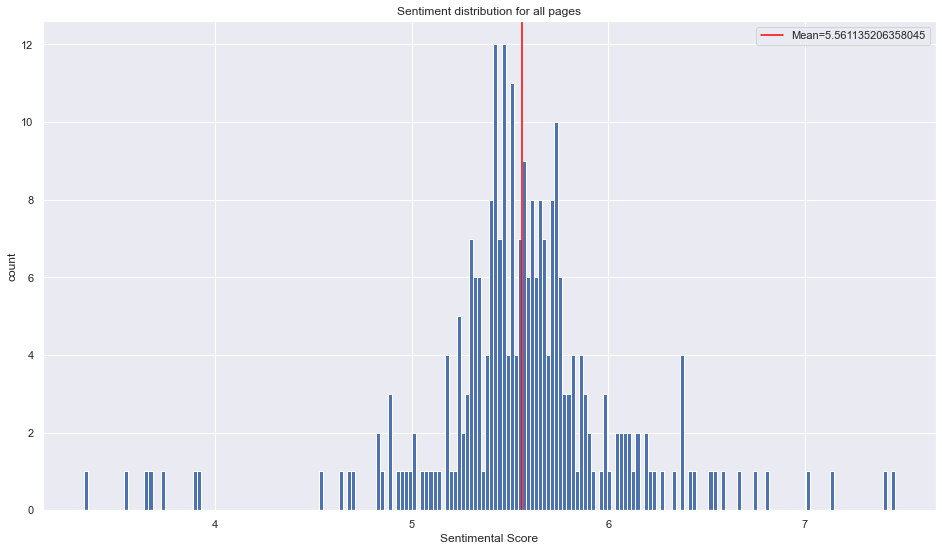

In [121]:
#Create a histogram of all character's associated page-sentiments.
import numpy as np 

plt.figure(figsize=(16,9))
plt.hist(char_sentiment.values(),bins=200)
sent_mean = np.mean((list(char_sentiment.values())))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

We can see that the sentimental score is somewhat neutral but compared to the wikipages it has more dispersion. Now it will be interesting to look at what are the saddest and happiest characters based on the lines in the script. Also the moving average of the movies is plotted to hopefully shed some light on how the sentiment changes during the film.

In [122]:
df.to_pickle("./movie_scripts.pkl")

In [123]:
unpickled_df = pd.read_pickle("./movie_scripts.pkl")

In [124]:
unpickled_df.head()

movie_nr sentence_number         character  \
0        1               1  Albus Dumbledore   
1        1               2        Mcgonagall   
2        1               3  Albus Dumbledore   
3        1               4        Mcgonagall   
4        1               5  Albus Dumbledore   

                                            sentence  \
0  I should have known that you would be here...P...   
1  Good evening, Professor Dumbledore. Are the ru...   
2   I'm afraid so, Professor. The good, and the bad.   
3                                       And the boy?   
4                            Hagrid is bringing him.   

                                      sentence_token  \
0  [i, should, have, known, that, you, would, be,...   
1  [good, evening, professor, dumbledore, are, th...   
2  [i, afraid, so, professor, the, good, and, the...   
3                                    [and, the, boy]   
4                        [hagrid, is, bringing, him]   

                                          scene_desc scene_id  sentence_sent  \
0  A neighbourhood on a street called Privet Driv...        1          5.740   
1  The cat meows, sniffs out and the camera pans ...        1          6.685   
2  The cat meows, sniffs out and the camera pans ...        1          4.635   
3  The cat meows, sniffs out and the camera pans ...        1          6.240   
4  The cat meows, sniffs out and the camera pans ...        1          6.040   

   scene_desc_sent  avg_scene_sent  avg_scene_desc_sent  
0         5.628438        5.950397             5.694964  
1         5.873000        5.950397             5.694964  
2         5.873000        5.950397             5.694964  
3         5.873000        5.950397             5.694964  
4         5.873000        5.950397             5.694964

Now we only want to look at characters that have certain amount of sentences or words that actually compount to a meaninful sentiment analysis. To do this the limit of words needed is set to be 25, that is 25 words that have a sentiment rating needs to be said by a character to be considered in the following sentiment analysis.

In [125]:
print("\nHappiest pages: ")
happy_charactes = pd.DataFrame(sorted(char_sentiment.items(), reverse=True, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happy_charactes)

print("\nUnhappiest pages: ")
unhappy_characters = pd.DataFrame(sorted(char_sentiment.items(), reverse=False, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(unhappy_characters)


Happiest pages: 


Page  Sentiment
1           Lavander Brown   7.460000
2                    Snake   7.400000
3   Justin-Finch-Fletchley   7.140000
4                  Charity   7.010000
5            Skinny Wizard   6.810000
6                Ron Harry   6.740000
7          Narcissa Malfoy   6.660000
8                    Class   6.590000
9            Riddle-—Harry   6.546667
10                  Viktor   6.530000


Unhappiest pages: 


Page  Sentiment
1            Waltress   3.330000
2   Disheveled Wizard   3.540000
3             Alastor   3.660000
4          Lily Evans   3.680000
5           Mrs Black   3.723333
6          Centaur #2   3.900000
7              Oiiver   3.910000
8        Young Wizard   4.533333
9        Young Hagrid   4.632500
10       Madam Sprout   4.690000

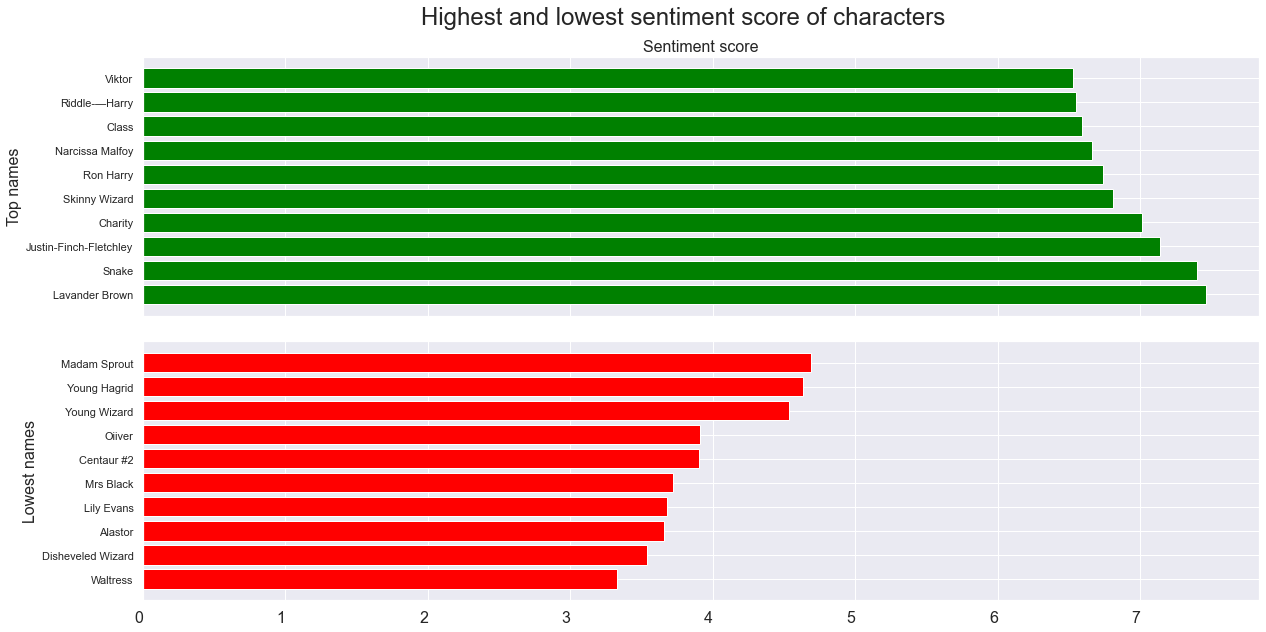

In [126]:
# Top 10 lowest and highest sentiment characters
best_name = sorted(char_sentiment, key=char_sentiment.get, reverse=False)[:10]
best_sent = [char_sentiment[x] for x in best_name]

worst = sorted(char_sentiment, key=char_sentiment.get, reverse=True)[:10]
worst_sent = [char_sentiment[x] for x in worst]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,10), gridspec_kw={'hspace': 0.1})

axes[0].barh(worst, worst_sent, color='green')
axes[0].set_title('Sentiment score', fontsize=16)
axes[0].set_ylabel('Top names', fontsize=16)

axes[1].barh(best_name, best_sent, color='red')
# axes[1].set_title('Sentiment score', fontsize=16)
axes[1].set_ylabel('Lowest names', fontsize=16)

# Set the rotation and horizontal alignment of the x tick labels
plt.setp(axes[0].get_xticklabels(), ha="left", fontsize=16);
plt.setp(axes[1].get_xticklabels(), ha="right", fontsize=16);

# Set plot title
plt.suptitle('Highest and lowest sentiment score of characters', fontsize=24, y = 0.95);

Here the saddest 10 and happiest 10 characeters are plotted. If we take a closer look those characters we can see that some of them have few lines that happen to be graded with high sentiment score. For instance Snake has the line Thanksssss, which is his only word in the film. To make this more meaningful a minimum limit of words containing a sentiment score will be applied for the filterin of the 10 happiest and saddest characters. 

In [157]:
snake_sent = df[df.character == 'Snake']['sentence'].values[0]
print('The sentence of the character Snake: ', snake_sent)

The sentence of the character Snake:  Thankssssssss.


In [161]:
df.iloc[40].sentence

"Mummy, dad, come here! You won't believe what this snake is doing!!"

In [127]:
#  TODO Create subplot with 7 figures and top 10 characters and their sentence count

#  Top 10 characters in each movie
# names = df['character'].value_counts()[:10].index

# Moving average plots of the sentiment

In [128]:
# function to plot moving average 

def m_avg(values,N): # takes in the values and the N of average (how many values to use)
    size = len(values)
    if size-N < 2:
        return(f'Short list or N too big.')
    else:
        cumsum, moving_aves = [0], []

        for i, x in enumerate(values, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                
                # add the the average vector
                moving_aves.append(moving_ave)
    return(moving_aves)

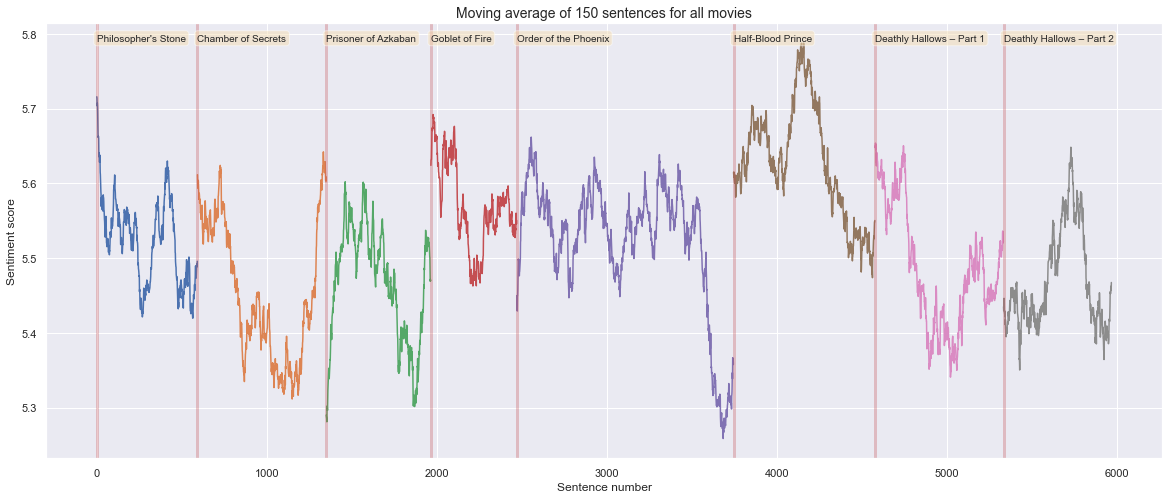

In [129]:
# Todo, finish up the moving average plot, set different colors on different movies
# m_avg(df.sent_sentence.dropna(),10)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))


moving_avg_total = [m_avg(df.sentence_sent[df.movie_nr == movie].dropna(),150) for movie in df.movie_nr.unique()]
# moving_avg_total = [item for sublist in moving_avg_total_2 for item in sublist]
moving_avg_index = [len(m_avg(df.sentence_sent[df.movie_nr == movie].dropna(),150)) for movie in df.movie_nr.unique()]
moving_avg_index = np.cumsum(moving_avg_index)


# plt.plot(moving_avg_total);
plt.xlabel('Sentence number')
plt.ylabel('Sentiment score')
plt.title('Moving average of 150 sentences for all movies', fontsize=14)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


for movie in range(1,9):
    x = moving_avg_index[movie-1]
    # place a text box in upper left in axes coords
    if movie > 1:
        plt.plot(np.arange(moving_avg_index[movie-2],moving_avg_index[movie-1]),moving_avg_total[movie-1])
        plt.axvline(x=moving_avg_index[movie-2], alpha = 0.3, color='r',lw=3);
        text_placement = moving_avg_index[movie-2]
    else:
        plt.plot(np.arange(0,moving_avg_index[movie-1]),moving_avg_total[movie-1])
        plt.axvline(x=0, alpha = 0.3, color='r', lw=3);
        text_placement = 0
    plt.text(text_placement, 5.8 , f'{movie_titles_short[movie-1]}', fontsize=10,
            verticalalignment='top', bbox=props)

## General statistics about the script data set:

### Creating count for various properties of the scripts

In [130]:
# Sentence count, that is the highset sentence number for each movie
sentence_count = []
for movie in df.movie_nr.unique():
    sentence_count.append(df.sentence_number[df.movie_nr == movie].max())
sentence_count

# Scene count
scene_count = []
for movie in df.movie_nr.unique():
    scene_count.append(df.scene_id[df.movie_nr == movie].max())
scene_count

# Character count
character_count = []
for movie in df.movie_nr.unique():
    character_count.append(len(df.character[df.movie_nr == movie].unique()))
character_count

# Combine all sentences for each movie
word_count = dict()
for movie in df.movie_nr.unique():
    text = df.sentence[df.movie_nr == movie].str.cat(sep=' ').split()
    word_count[movie] = len(text)

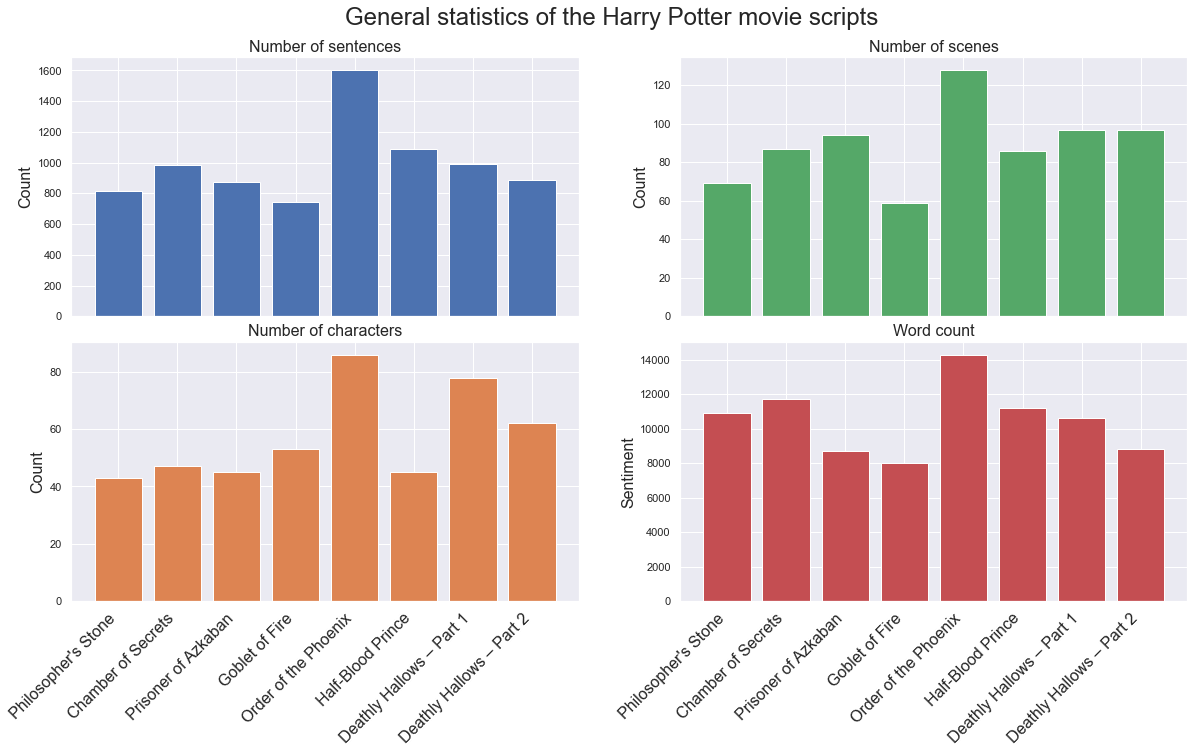

In [131]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(20,10), gridspec_kw={'hspace': 0.1})

palette = itertools.cycle(sns.color_palette())

axes[0][0].bar(movie_titles_short, sentence_count, width = 0.8, color=next(palette))
axes[0][0].set_title('Number of sentences', fontsize=16)
axes[0][0].set_ylabel('Count', fontsize=16)

axes[1][0].bar(movie_titles_short, character_count, width = 0.8, color=next(palette))
axes[1][0].set_title('Number of characters', fontsize=16)
axes[1][0].set_ylabel('Count', fontsize=16)

axes[0][1].bar(movie_titles_short, scene_count, width = 0.8, color=next(palette))
axes[0][1].set_title('Number of scenes', fontsize=16)
axes[0][1].set_ylabel('Count', fontsize=16)

axes[1][1].bar(movie_titles_short, word_count.values(), width = 0.8, color=next(palette))
axes[1][1].set_title('Word count', fontsize=16)
axes[1][1].set_ylabel('Sentiment', fontsize=16)

# Set the rotation and horizontal alignment of the x tick labels
plt.setp(axes[1][0].get_xticklabels(), rotation=45, ha="right", fontsize=16);
plt.setp(axes[1][1].get_xticklabels(), rotation=45, ha="right", fontsize=16);

# Set plot title
plt.suptitle('General statistics of the Harry Potter movie scripts', fontsize=24, y = 0.95);

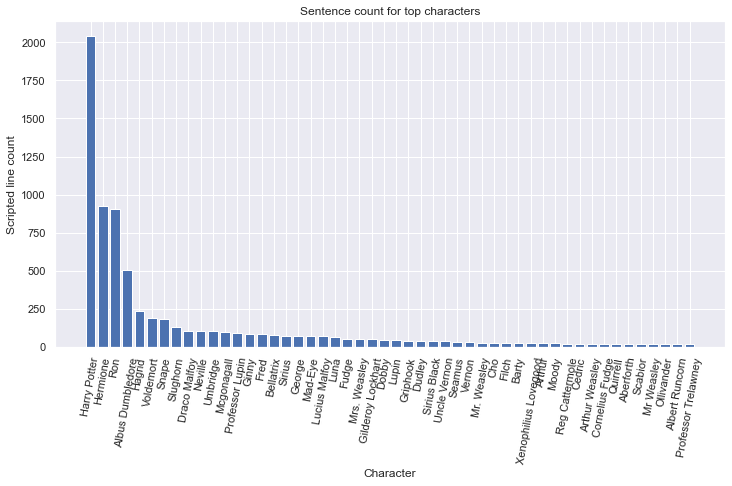

In [132]:
# Look at the top speaking characters and plot the total sentence count 
names = df['character'].value_counts()[:50].index
value = df['character'].value_counts()[:50]
# # Preparing figure
plt.figure(figsize=(12,6))

plt.bar(names,value,width=0.8)
plt.title('Sentence count for top characters')
plt.xlabel('Character')
plt.ylabel('Scripted line count')
plt.xticks(rotation=80)
plt.show()

Here we can see how the characters sentence count is plotted for the top 50 characters of the movies. This plot is based on all the movies and it can be seen how Harry, Hermione and Ron dominate on the top with around 4000 sentences combined, throughout all the movies.

In [133]:
#  Create dictionary for word count and average word count per character
character_sentences_wordcount = {}
characharacter_sentences_avg_wordcount = {}

for char in char_sentences:
    character_sentences_wordcount[char] = len(char_sentences[char])
    characharacter_sentences_avg_wordcount[char] = len(char_sentences[char])/len(df[df.character == char])

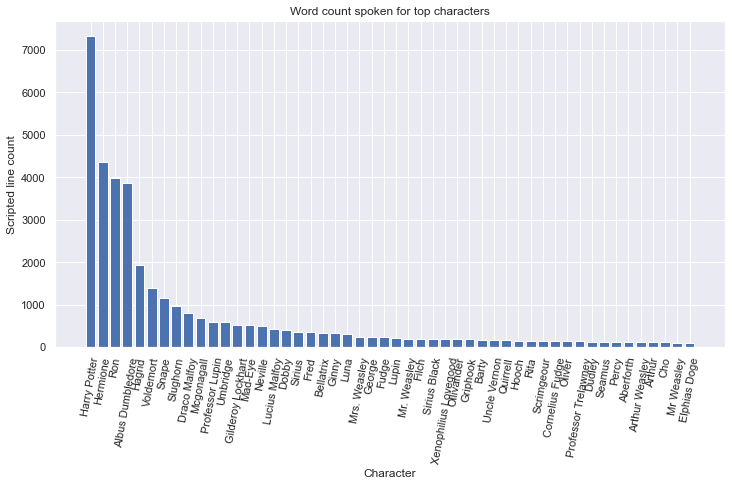

In [134]:
# Look at the characters with most words spoken
names = sorted(character_sentences_wordcount, key=character_sentences_wordcount.get, reverse=True)[:50]
values = [character_sentences_wordcount[x] for x in names]

plt.figure(figsize=(12,6))

plt.bar(names,values,width=0.8)
plt.title('Word count spoken for top characters')
plt.xlabel('Character')
plt.ylabel('Scripted line count')
plt.xticks(rotation=80)
plt.show()

We now look at the total amount of spoken words by the top 50 largest ones. Here again similar to the amount of sentences, the three top characters stay the same. It can be seen that the difference between the trio, and Albus Dumbledore is much less, this indicates that albus has a higher average sentence length compared to the top 3. To further investigate the nature of the sentences and what characters are usually speaking longer than other in each line they have we look at the top 50 average length sentences of all characters.

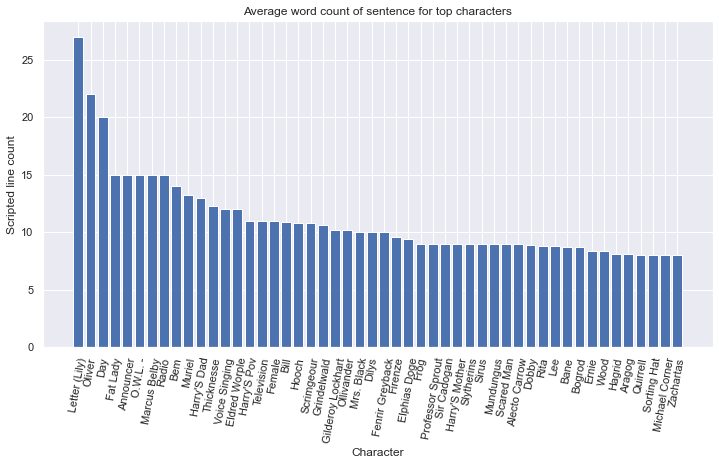

In [135]:
# Look at the characters with most words spoken
names = sorted(characharacter_sentences_avg_wordcount, key=characharacter_sentences_avg_wordcount.get, reverse=True)[:50]
values = [characharacter_sentences_avg_wordcount[x] for x in names]

plt.figure(figsize=(12,6))

plt.bar(names,values,width=0.8)
plt.title('Average word count of sentence for top characters')
plt.xlabel('Character')
plt.ylabel('Scripted line count')
plt.xticks(rotation=80)
plt.show()

Here we can clearly see that the average count of words per sentence is for characters that are less dominant in the movies and usually have few but long lines. If we take close look to those characters to understand what they really are 

In [155]:
print('The sentence for the "Character" Letter (Lily)')
df[df.character == 'Letter (Lily)'].sentence.values[:]

The sentence for the "Character" Letter (Lily)


array(['Dear Sirius. Thank you for Harry’s birthday present. You’d',
       'James says he’s got the look of a Seeker, but then James would. We had a very guiet birthday tea, just us and old Bathilda, who dotes on Harry. Wormy dropped by late in the day, but seemed down and didn’t stay long. James is frustrated being shut up here, but Dumbledore’s still got his Invisibility Cloak, so he doesn’t have much choice. By the way, Bathilda tells the most amazing stories about our old Headmaster. I don’t know how much to believe. Can it really be true that Dumbledore - Harry turns the letter over, but there is no more.'],
      dtype=object)

Here we can see that we are looking at the text spoken by the magical letter written by Harry's mother Lily. Since a letter is usually longer then a chracter line there is no surpsie why this has the longest average sentece out of all characters.

# Wordclouds for characters

Lets create frequency distribution for all characters and examine how their respective word clouds look like.

In [194]:
#  Term frequency for all the movie lines
# Lets combine all sentences for each movie into a dictionary
all_movie_sentences = {}
text = tokenize(df.sentence.str.cat(sep=' '))
all_movie_sentences = text
all_movie_tf = nltk.FreqDist(all_movie_sentences)

In [195]:
most_names = all_movie_tf.most_common(20)[::-1]
names = [x[0] for x in most_names]
values = [x[1] for x in most_names]

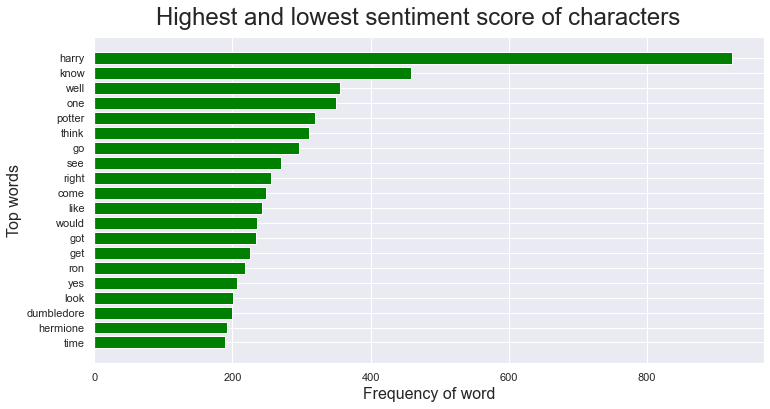

In [196]:
plt.figure(figsize=(12,6))
plt.barh(names,values, color='green')
plt.ylabel('Top words', fontsize=16)
plt.xlabel('Frequency of word',fontsize=16)

# Set plot title
plt.suptitle('Highest and lowest sentiment score of characters', fontsize=24, y = 0.95);

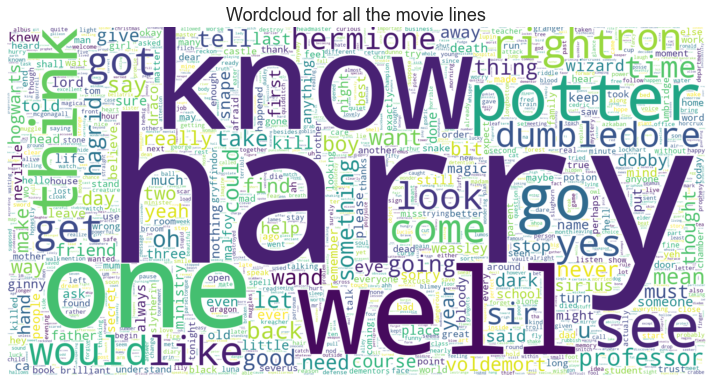

In [197]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Define the settings and input to the wordclouds - DC
wordcloud_all_books = WordCloud(background_color='white',
                         width=2000,
                         max_words=2000,
                         height=1000, 
                         colormap="viridis",
                         random_state = 42
                         #contour_width=1, 
                         #contour_color='steelblue'
                        ).generate_from_frequencies(all_movie_tf)

plt.figure(figsize=(10,10))

plt.imshow(wordcloud_all_books, interpolation='bilinear')
plt.title("Wordcloud for all the movie lines", fontsize=18)
plt.axis("off")
plt.tight_layout()
# plt.savefig(f'../images/scripts/all_line_wordcloud.png')

In [136]:
#  First lets select interesting characters 
interesting_list = ['Dobby','Harry Potter','Hermione','Ron','Snape','Voldemort','Bellatrix','Mcgonagall']
figure_ref = ['dobby','harry','hermione','ron','snape','voldemort','bellatrix','mcgonagall']

# Create a dictionary of frequency distribution for all characters
character_freqdist = {}
for char in df.character.unique():
    character_freqdist[char] = nltk.FreqDist(char_sentences[char])
    
movie_freqdist = {}
for movie in df.movie_nr.unique():
    movie_freqdist[movie] = nltk.FreqDist(movie_sentences[movie])

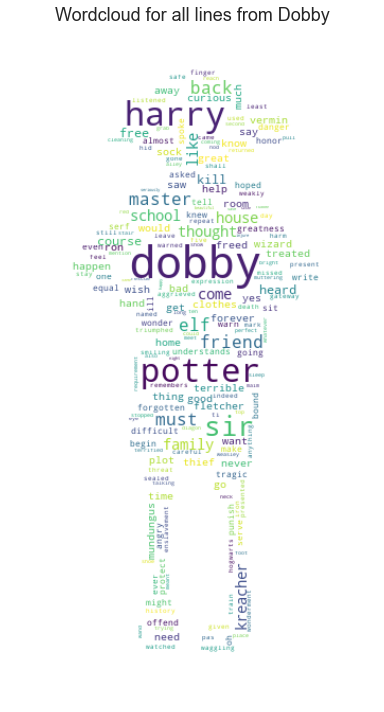

In [137]:
from os import path
from PIL import Image
import os

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
hp_mask = np.array(Image.open(path.join(d, f'data/char_images/{figure_ref[0]}.jpg')))

# Define the settings and input to the wordclouds - DC
wordcloud_all_books = WordCloud(background_color='white',   
                         width=1000,
                         max_words=2000,
                         height=1000, 
                         colormap="viridis",
                         mask = hp_mask,
                         random_state = 42
                         #contour_width=1, 
                         #contour_color='steelblue'
                        ).generate_from_frequencies(character_freqdist['Dobby'])

plt.figure(figsize=(10,10))

plt.imshow(wordcloud_all_books, interpolation='bilinear')
plt.title("Wordcloud for all lines from Dobby", fontsize=18)
plt.axis("off")
plt.tight_layout()

In [138]:
# Collect the word cloud objects into a dictionary
wordclouds = {}

for idx, char in enumerate(interesting_list):
    
    color_maps = ["viridis", "plasma", "inferno", "magma", "cividis"]
    
    random_color_map = random.choice(color_maps)
    
    hp_mask = np.array(Image.open(path.join(d, f'data/char_images/{figure_ref[idx]}.jpg')))
    
    wordclouds[idx] = WordCloud(background_color='white',
                                 width=1000,
                                 max_words=2000,
                                 height=1000, 
                                 colormap="viridis",
                                 mask = hp_mask,
                                 random_state = 42
                                 #contour_width=1, 
                                 #contour_color='steelblue'
                                ).generate_from_frequencies(character_freqdist[char])
    


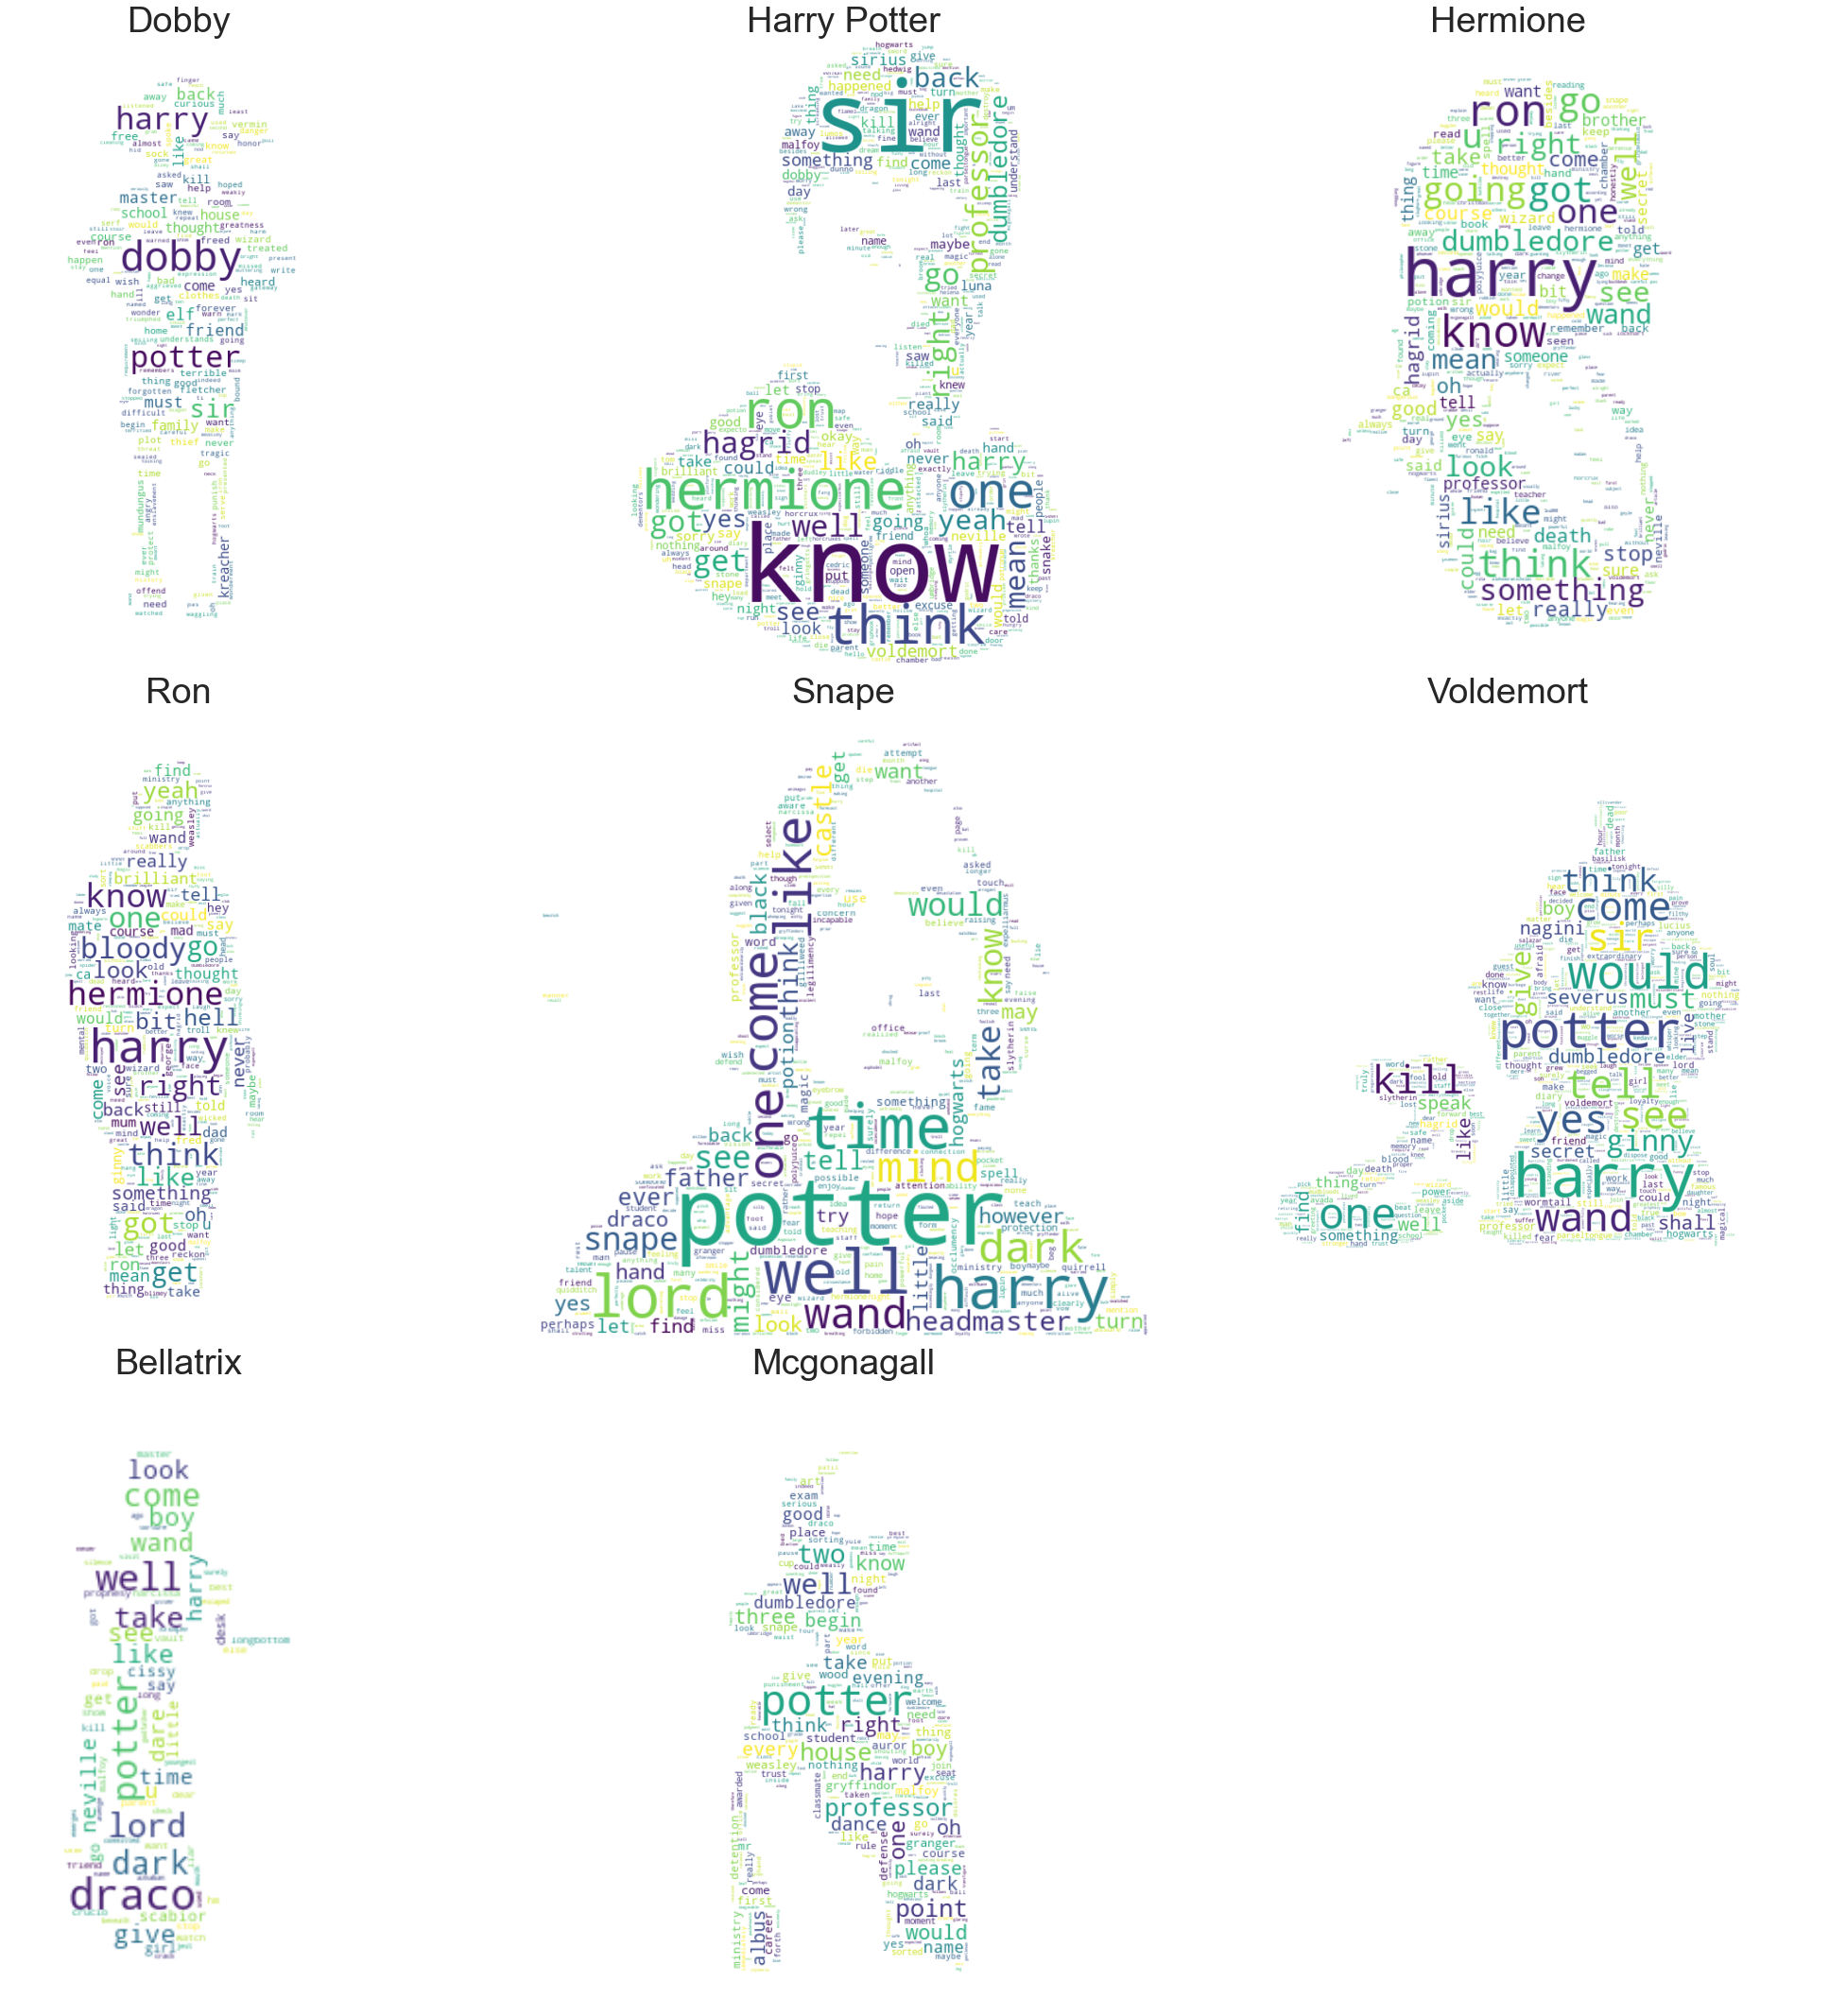

In [139]:
# Generate a single figure
plt.figure(figsize=(30,30))

for idx, community_number in enumerate(wordclouds):
    plt.subplot(3, 3, idx+1);
    plt.imshow(wordclouds[idx], interpolation='bilinear');
    plt.title(interesting_list[idx], size = 38);
    plt.tight_layout();
    plt.axis("off");

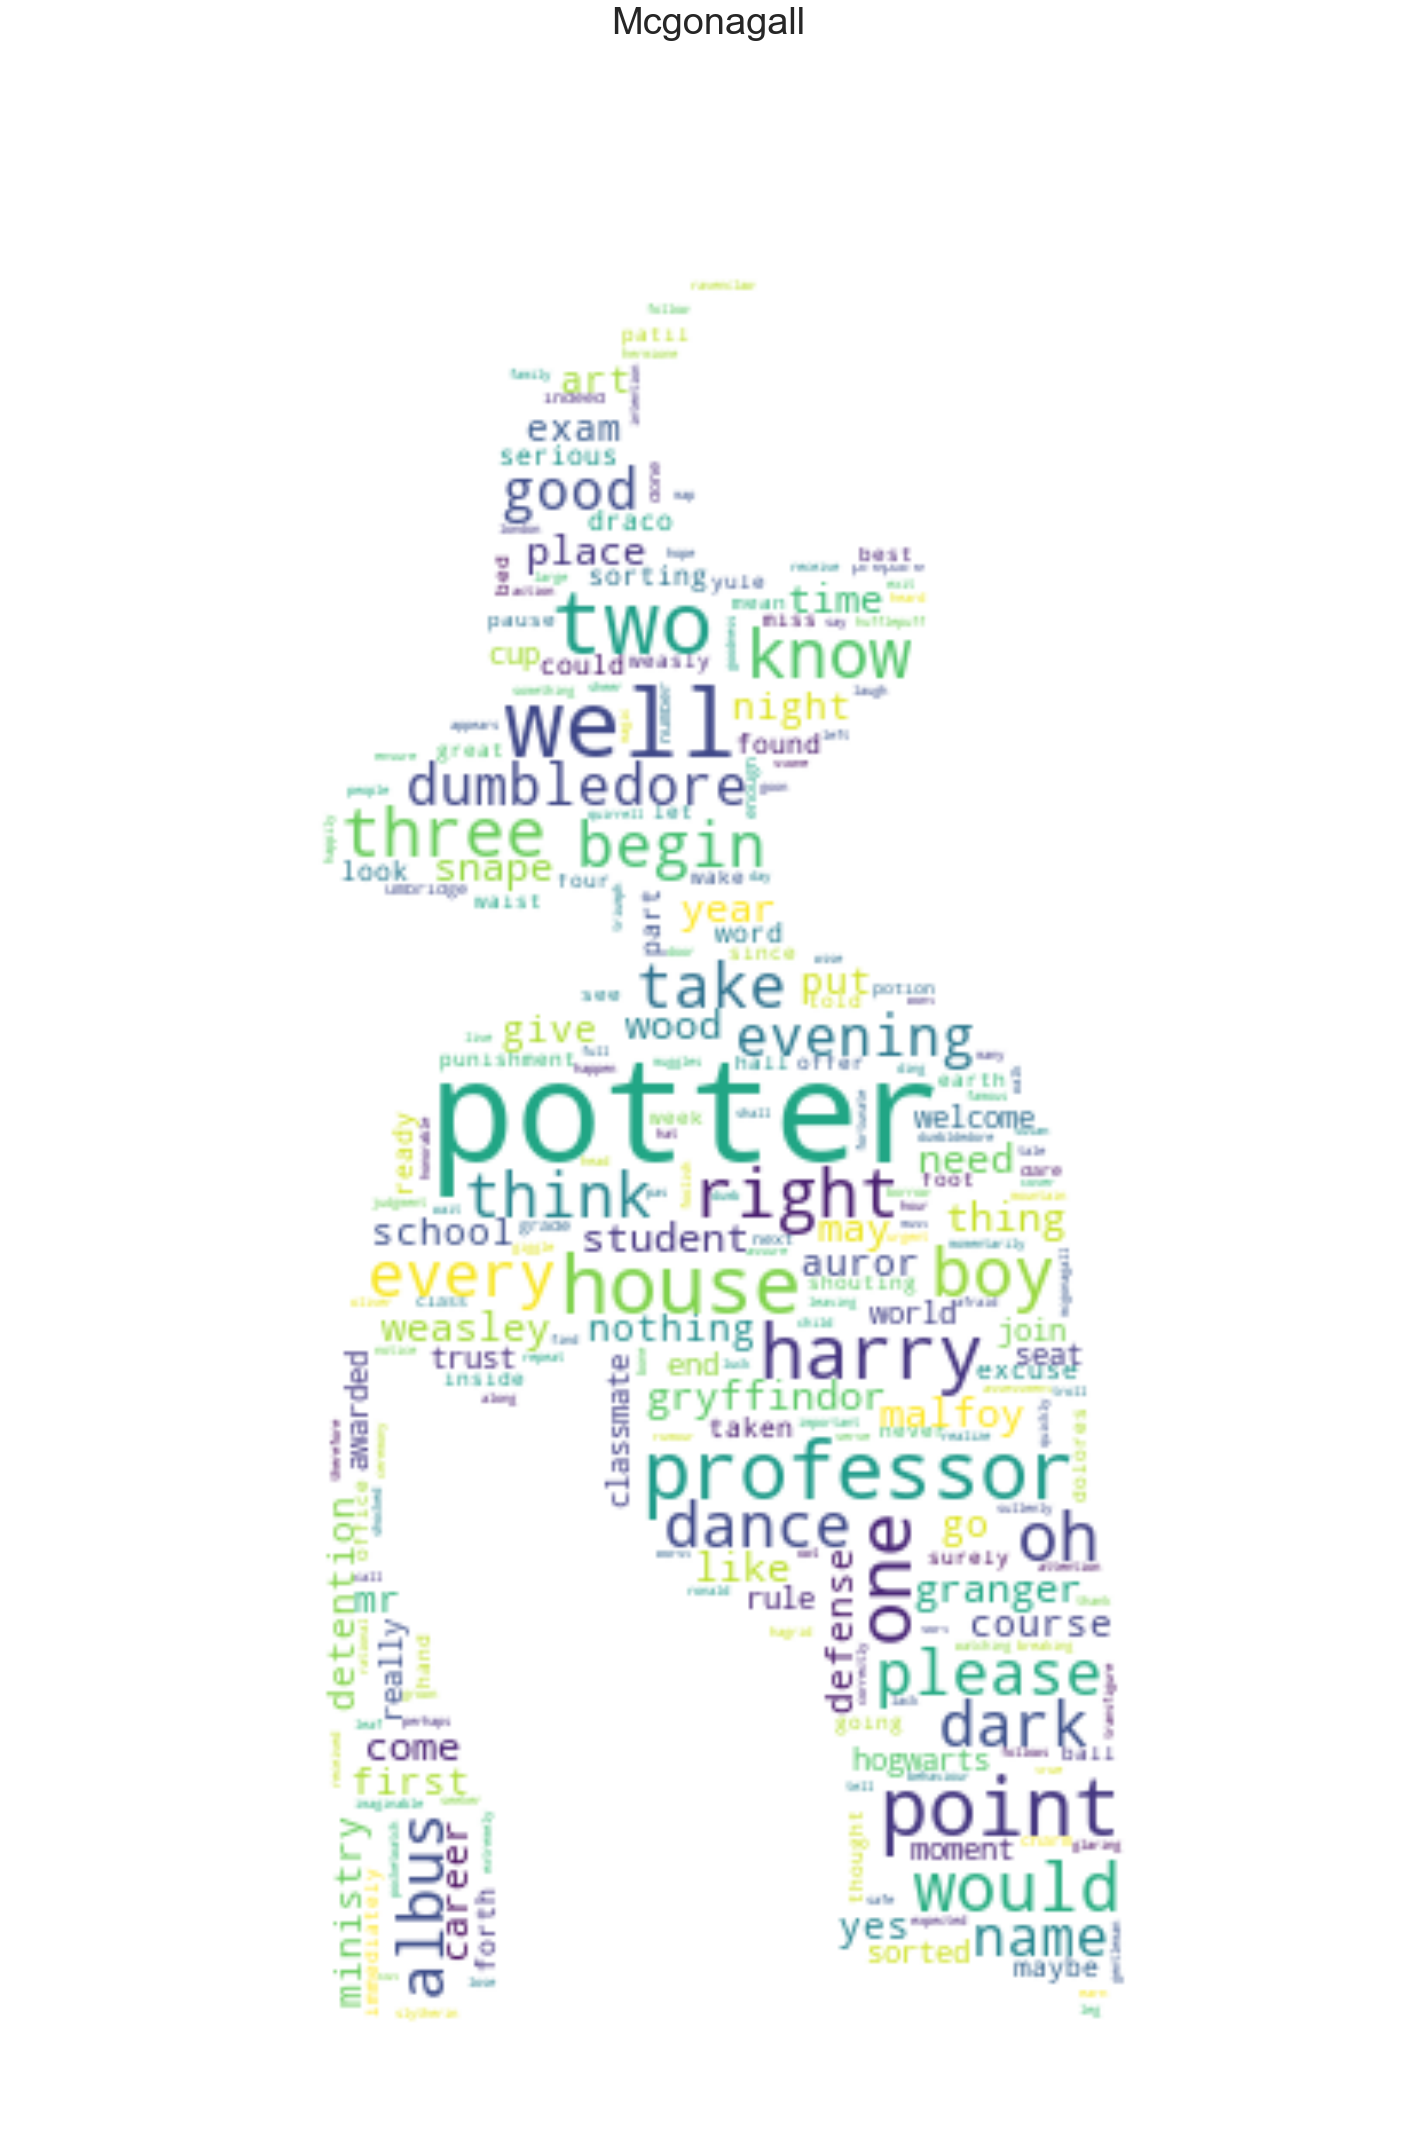

In [142]:
#  Save figure to individual pictures 
# Generate a single figure
plt.figure(figsize=(30,30))

for idx, community_number in enumerate(wordclouds):
    plt.imshow(wordclouds[idx], interpolation='bilinear');
    plt.title(interesting_list[idx], size = 38);
    plt.tight_layout();
    plt.axis("off");
    plt.savefig(f'./data/char_images/char_wordclouds/{interesting_list[idx]}_wordcloud.png')

Now if we look at the term frequencies of the movies as a whole

In [198]:
# Collect the word cloud objects into a dictionary
wordclouds = {}

for idx, movie in enumerate(df.movie_nr.unique()):
    
    color_maps = ["viridis", "plasma", "inferno", "magma", "cividis"]
    
    random_color_map = random.choice(color_maps)
    
    wordclouds[idx] = WordCloud(collocations=False, 
                                             background_color='White', 
                                             width=800, 
                                             height=400, 
                                             colormap="viridis",
                                             random_state=42
                                             #stopwords = manual_stopwords  ### this does not work with generate_from_frequencies
                        ).generate_from_frequencies(movie_freqdist[movie])
    


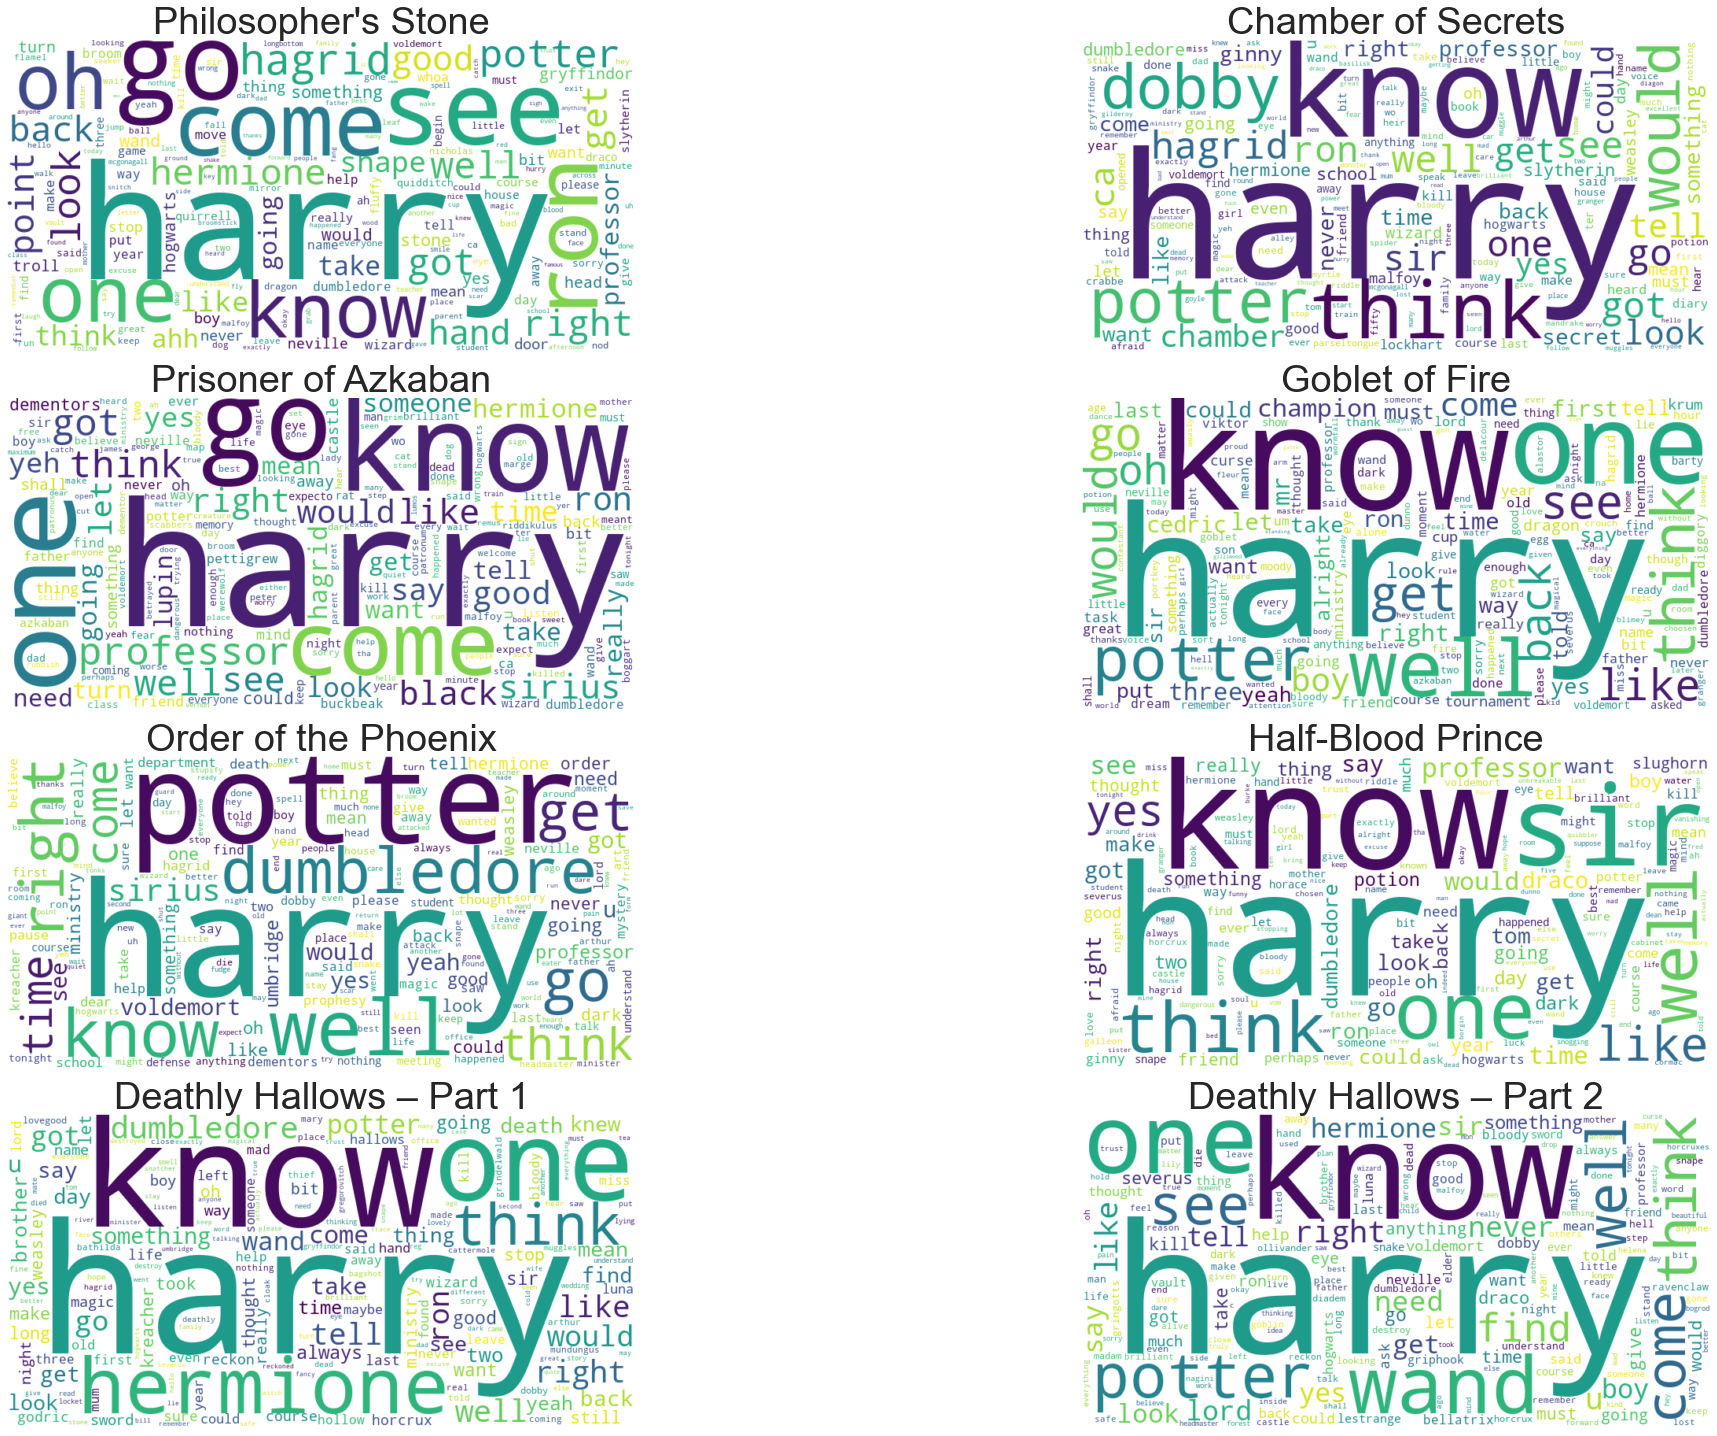

In [199]:
# Generate a single figure
plt.figure(figsize=(30,30))

for idx, community_number in enumerate(wordclouds):
    plt.subplot(6, 2, idx+1);
    plt.imshow(wordclouds[idx], interpolation='bilinear');
    plt.title(movie_titles_short[idx], size = 38);
    plt.tight_layout();
    plt.axis("off");

# Network creation and analysis


### Create character connections based on how many times they are in the same scene in the movies

The idea here is that characters that act in the same scene in the movie have some kind of a connection or interaction. Here the oppurtinity to create a weighted graph clearly possible and each edge weight is based on how many scenes characters are in togheter.

In [210]:
# Add one between characters that are in the same scene

scene_interactions = dict()
for movie in df.movie_nr.unique():
    df_store = df[df.movie_nr == movie].groupby(['scene_id'])['character'].unique()
    for scene in df_store:
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1

Since this a weighted graph the tuple create for scene_interanction is on the form. <b>[('Hagrid', 'Harry Potter'): 46]</b>, where 46 is the count of scenes that Hagrid and Harry are in together. This information is stored as the weight of the edge in the graph. Now the undirected weighted network is created and we look into the top connected characters.

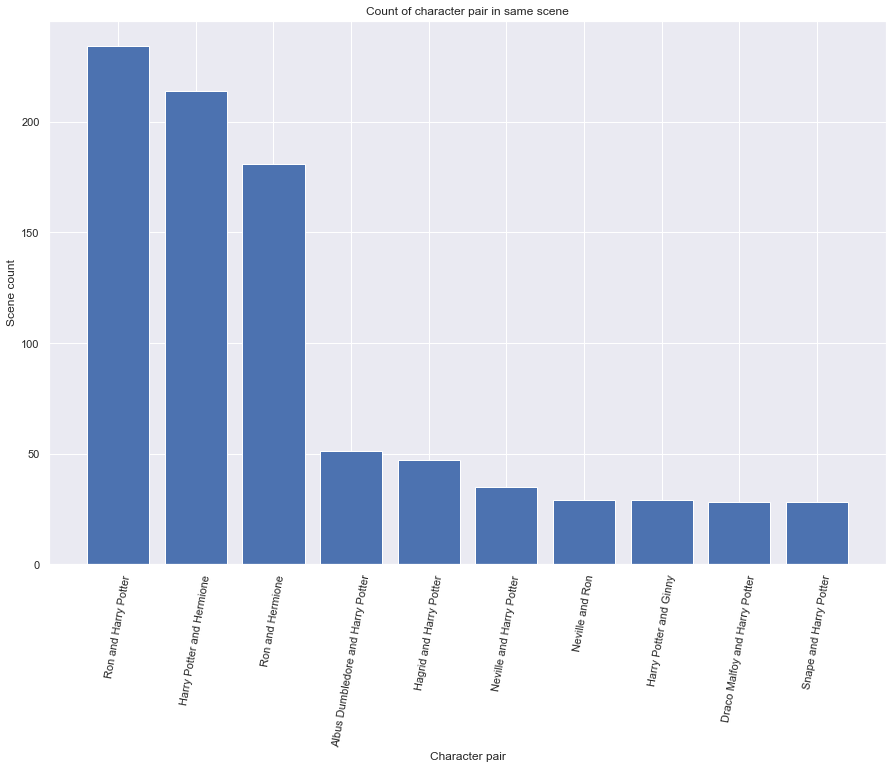

In [211]:
top_10 = sorted(scene_interactions, key=scene_interactions.get, reverse=True)[:10]
names = [' and '.join(i) for i in top_10]

top_10_dict = { your_key: scene_interactions[your_key] for your_key in top_10 }

plt.figure(figsize=(15,10))

plt.bar(names,top_10_dict.values(),width=0.8)
plt.title('Count of character pair in same scene')
plt.xlabel('Character pair')
plt.ylabel('Scene count')
plt.xticks(rotation=80)
plt.show()

In [203]:
with open('char_interactions.pickle', 'wb') as handle:
    pickle.dump(scene_interactions, handle, protocol=pickle.HIGHEST_PROTOCOL)

Here we can see how the trio of Harry, Ron and Hermione is by far largest of all the interactions in the harry potter movies.

In [212]:
G = nx.Graph()

# Create an undirected weighted graph
G = nx.Graph()
for edge in scene_interactions:
    edge_1 = edge[0]
    edge_2 = edge[1]
    weight = scene_interactions[edge]
    G.add_edges_from([(edge_1, edge_2, {'weight': weight})])

The highest connected component is extracted from the graph and the louvine community algorithm is applied to get the communities of the network.

In [222]:
# Extracting the GCC
G_GCC = G.subgraph(max(nx.connected_components(G), key=len))
partition = community.best_partition(G_GCC, random_state = 0)

In [223]:
# Create a dictionary of node name and community number
communities = {}
for node in G_GCC.nodes:
    communities[node] = partition[node]
        
# Get all the community values in a single variable for counting
lovain_communities = communities.values()

# Count and sort the communities
communities_counter = Counter(lovain_communities).most_common(max(lovain_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(G_GCC, communities, "community")

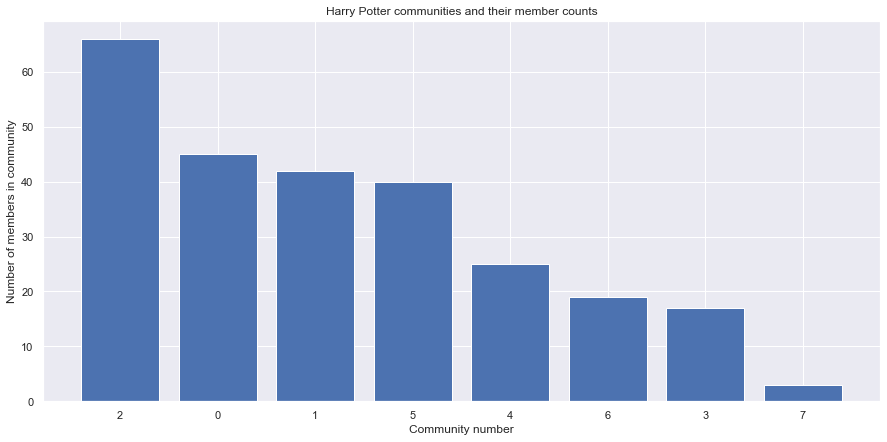

In [224]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of members in community')
plt.title('Harry Potter communities and their member counts')
plt.show()

Here we can see some strong communities and the total communities of the network is 7. Now we go into further anlysis and look at the communities indvidually and plot the network based on those communities

In [225]:
communities_to_nodes = {}

for node in partition:
    if not communities_to_nodes.get(partition[node]):
        communities_to_nodes[partition[node]] = []
    communities_to_nodes[partition[node]].append(node)

In [226]:
for community_name in communities_to_nodes.keys():
    curr_comm = communities_to_nodes[community_name]
    curr_com_with_degrees = []
    for member in curr_comm:
        curr_com_with_degrees.append([member, G_GCC.degree(member)])
    top_members = sorted(curr_com_with_degrees, key=lambda x: x[1], reverse=True)[:10]
    top_members_pd = pd.DataFrame(top_members) 
    display(top_members_pd)

0   1
0   Albus Dumbledore  71
1              Snape  60
2              Filch  27
3            Mad-Eye  27
4           Umbridge  24
5              Voice  23
6  Gilderoy Lockhart  21
7              Fudge  17
8             Cormac  17
9              Barty  16

0   1
0       Neville  72
1  Draco Malfoy  70
2    Mcgonagall  43
3        Seamus  43
4           All  27
5         Percy  23
6         Hooch  22
7           Boy  19
8      Students  18
9          Girl  17

0    1
0          Harry Potter  217
1                   Ron  168
2              Hermione  161
3                Hagrid   65
4              Slughorn   25
5                 Dobby   18
6        Reg Cattermole   15
7        Lavender Brown   13
8        Albert Runcorn   13
9  Xenophilius Lovegood   11

0   1
0          Dudley  20
1         Petunia  17
2          Vernon  17
3       Mrs. Figg  17
4     Lily Potter  14
5           Moody  13
6    Gang Thug #1  12
7  Gang Member #3  12
8        Kingsley  12
9    Sirius Black   9

0   1
0      Voldemort  49
1  Lucius Malfoy  40
2      Bellatrix  31
3       Wormtail  19
4         Yaxley  19
5         Cedric  17
6       Narcissa  11
7     Thicknesse  11
8     Ollivander  10
9    Death Eater   9

0   1
0           Ginny  57
1            Fred  52
2          George  49
3           Lupin  45
4           Tonks  29
5    Mrs. Weasley  25
6          Sirius  22
7     Mr. Weasley  21
8  Arthur Weasley  17
9           Fleur  16

0   1
0                   Luna  41
1                    Cho  22
2            Susan Bones  21
3             Lee Jordan  21
4                  Ernie  17
5               Angelina  16
6             Zachartias  16
7  Justin Finch-Fletchly  16
8         Michael Corner  16
9         Lavander Brown  16

0  1
0      Stan Shunpike  3
1  Disheveled Wizard  3
2      Shrunken Head  3

0  1
0  Mrs. Granger  3
1   Mr. Granger  3
2    Television  3

In [229]:
community_nodes = {} # node as key and value as community
community_included = {} # community as key and all nodes as value
for com in set(list(communities.values())):
    nodes_in_com = [k for k,v in communities.items() if v == com] # group all nodes with same community
    most_connected = sorted(G_GCC.degree(nodes_in_com), key=lambda x: x[1], reverse=True) # most connected nodes
    name_length = 0 # initialize the name length
    name = '' 
    node_count = len(most_connected)
    # create the name, take care if there 

    while name_length < 3 and name_length < node_count:
        if name_length > 0 and name_length < 3:
            name += "|" + most_connected[name_length][0]
        else:
            name += most_connected[name_length][0]
        name_length += 1
    
    # Go through all the nodes in the community and set the 3 most connected characters as name
    for node in nodes_in_com:
        community_nodes[node] = name
        
    community_included[name] = nodes_in_com # put the newly created name
    
nx.set_node_attributes(G_GCC, community_nodes, "community")

In [227]:
# Generate the numbers of the top 10 communities and top 6 communities
top_10_communities = [el[0] for el in Counter(lovain_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G_GCC).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

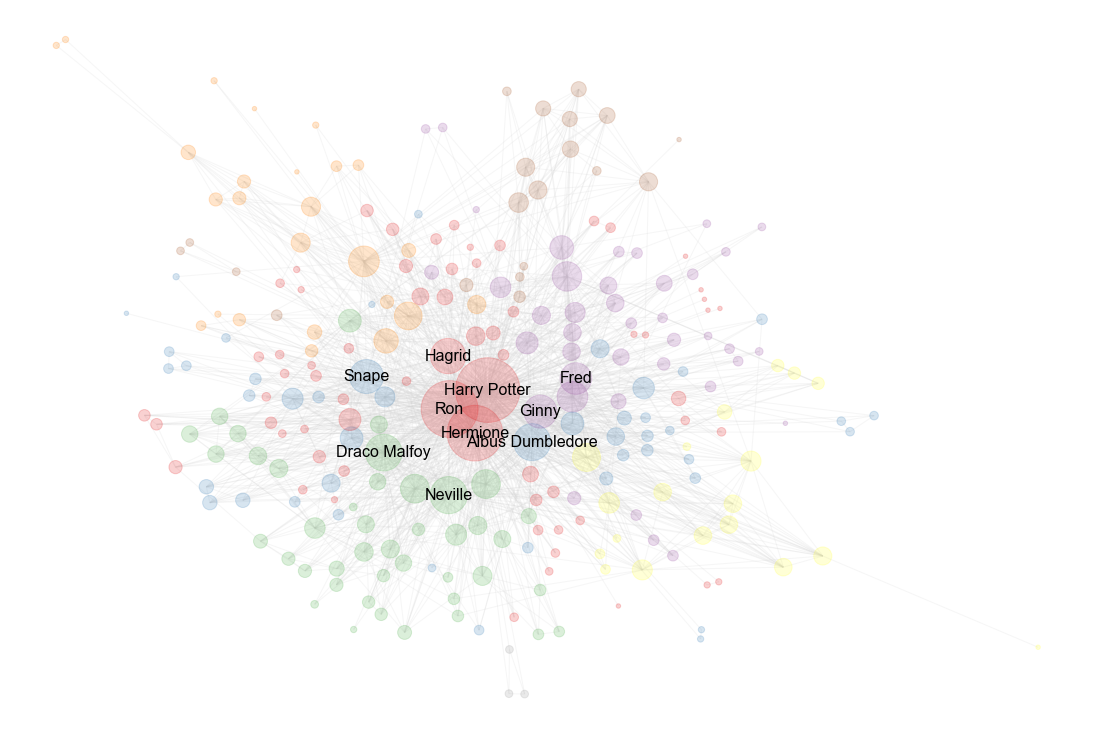

In [228]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
import matplotlib as mtpl
from fa2 import ForceAtlas2

cmap = mtpl.cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))


plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G_GCC, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(G_GCC).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in lovain_communities]

# Generate the graph
nx.draw(G_GCC, positions, with_labels = False, node_size = node_sizes,
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}
for node in G_GCC.nodes():
    if node in top_nodes[:10]:
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G_GCC, positions, labels, font_size=16, font_color='black');

In [233]:
community_included.keys()

dict_keys(['Albus Dumbledore|Snape|Filch', 'Neville|Draco Malfoy|Mcgonagall', 'Harry Potter|Ron|Hermione', 'Dudley|Petunia|Vernon', 'Voldemort|Lucius Malfoy|Bellatrix', 'Ginny|Fred|George', 'Luna|Cho|Susan Bones', 'Stan Shunpike|Disheveled Wizard|Shrunken Head', 'Mrs. Granger|Mr. Granger|Television'])

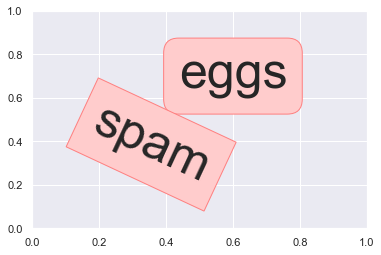

In [241]:
figure = plt.figure()

plt.text(0.6, 0.7, "eggs", size=50,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.text(0.55, 0.6, "spam", size=50, rotation=-25.,
         ha="right", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.show()

<font color='red'> Add the 3 most connected as a print statement below to show who are in the other colors</font>

<font size=5 color='red'>NICE TODO: Create network for each movie and make a transition between them to show how the communities change over the movies</font>

Those are some very interesting results and we can clearly see that the communities created by the louvine is somewhat what one would expect if he has seen the movies. Here we have the trio of Hermione, Harry and Ron, along with Hagrid their good friend.

### Trying different method of weighted network

Now instead of looking at the scene-id and connect characters together in that way, we turn to the sentences that the characters say. The sentences are used to link characters together with a directed weighted network, where the weight is determined by how often a character mentions another character. The link is created if a mention exists otherwise there is no link. Here it will be interesting to see how characters that talk frequently too or about each other will be linked together.

In [49]:
#  Count mentions between characters
char_list = df.character.str.lower().unique() # Lower the characters names since they are not always capital letters

# Create reference connection dictionary
ref_connection = {}

#  Go through every unique character in the dataframe and make a reference dictionary
for char in char_list:
    df_slice = df[df.character.str.lower() != char].copy()
    df_slice.sentence = df_slice.sentence.str.lower()
    ref_list = list(df_slice.character[df_slice.sentence.str.contains(char)])
    if ref_list:
        ref_connection[char.title()] = ref_list
#  Count mentions between characters


/Users/hlynurarnisigurjonsson/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [50]:
# Create the ref_weighted list that contains the directed weight
ref_weight = []
# for char in ref_connection:
from collections import Counter

char = ref_connection['Albus Dumbledore']
listi = [Counter(char).items()]
    
for char in ref_connection:
    char_con = ref_connection[char]
    listi = [Counter(char_con).items()]
    for count in listi[0]:
        ref_weight.append((char,count[0],{'weight': count[1]}))

In [51]:
GD = nx.DiGraph(ref_weight)

#  Create largest component subgraph
GD_GCC = GD.subgraph(max(nx.weakly_connected_components(GD)))

# Also create an undirected version for plotting later on
GD_GCC_und = nx.to_undirected(GD_GCC)

In [52]:
partition = community.best_partition(GD_GCC_und, random_state = 0)

In [53]:
# Create a dictionary of node name and community number
communities = {}
for node in GD_GCC_und.nodes:
    communities[node] = partition[node]
        
# Get all the community values in a single variable for counting
lovain_communities = communities.values()  

# Count and sort the communities
communities_counter = Counter(lovain_communities).most_common(max(lovain_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(GD_GCC_und, communities, "community")

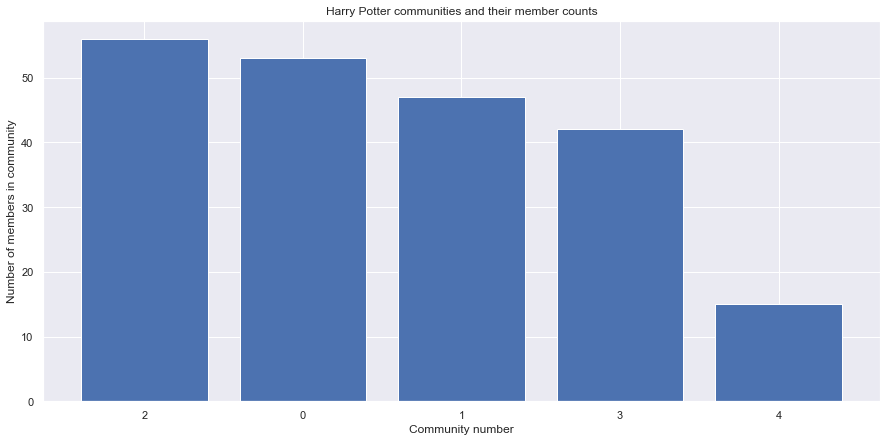

In [54]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of members in community')
plt.title('Harry Potter communities and their member counts')
plt.show()

In [55]:
communities_to_nodes = {}

for node in partition:
    if not communities_to_nodes.get(partition[node]):
        communities_to_nodes[partition[node]] = []
    communities_to_nodes[partition[node]].append(node)

In [56]:
for community_name in communities_to_nodes.keys():
    curr_comm = communities_to_nodes[community_name]
    curr_com_with_degrees = []
    for member in curr_comm:
        curr_com_with_degrees.append([member, GD_GCC_und.degree(member)])
    top_members = sorted(curr_com_with_degrees, key=lambda x: x[1], reverse=True)[:10]
    top_members_pd = pd.DataFrame(top_members)
    display(top_members_pd)

0   1
0  Albus Dumbledore  79
1             Snape  55
2         Voldemort  49
3               Cho  48
4        Mcgonagall  44
5             Night  40
6          Umbridge  37
7             Lupin  27
8              Girl  26
9           Student  23

0    1
0                All  115
1             Hagrid   60
2       Draco Malfoy   40
3            Mad-Eye   33
4               Fred   33
5             George   27
6      Lucius Malfoy   26
7  Gilderoy Lockhart   19
8              Fudge   18
9               Bill   17

0    1
0  Harry Potter  139
1           Ron  134
2      Hermione  113
3       Neville   46
4        Sirius   36
5        Friend   34
6         Ginny   33
7          Luna   28
8           Lee   25
9         Voice   20

0   1
0                  Day  64
1                  Boy  58
2                  Tom  29
3             Slughorn  28
4            Bellatrix  28
5                 Boys  19
6                 Rita  17
7                Percy  16
8               Dudley  14
9  Professor Trelawney  14

0   1
0           Arthur  28
1     Mrs. Weasley  23
2   Arthur Weasley  20
3            Tonks  17
4          Morning  15
5       Mr Weasley  12
6   Albert Runcorn   8
7   Reg Cattermole   7
8  Mary Cattermole   6
9             Amos   5

0   1
0  Professor Lupin  26
1     Sirius Black  21
2            James  13
3        Pettigrew  11
4    Stan Shunpike   8
5         Patronus   7
6         Fat Lady   5
7      Susan Bones   3
8      Dean Thomas   3
9       Lily Evens   3

In [57]:
# Generate the numbers of the top 10 communities and top 6 communities
top_10_communities = [el[0] for el in Counter(lovain_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(GD_GCC_und).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

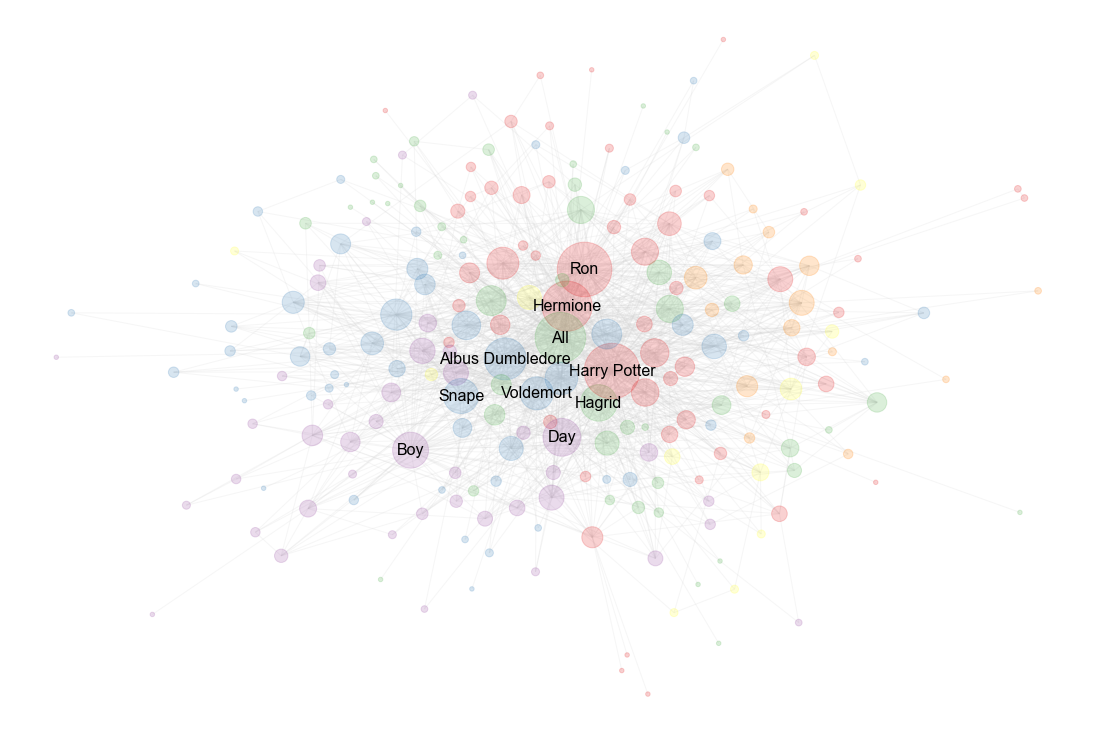

In [58]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
import matplotlib as mtpl
from fa2 import ForceAtlas2

cmap = mtpl.cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))


plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(GD_GCC_und, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(GD_GCC_und).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in lovain_communities]

# Generate the graph
nx.draw(GD_GCC_und, positions, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}
for node in GD_GCC_und.nodes():
    if node in top_nodes[:10]:
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(GD_GCC_und, positions, labels, font_size=16, font_color='black');

Here we have characters names as words, this includes Day, Boy and All. It doesn't comeas a surpise that those words would end up as big notes in the network. We will deliberately remove them when creating the graph again.

In [59]:
#  Count mentions between characters
char_list_temp = df.character.str.lower().unique() # Lower the characters names since they are not always capital letters
remove_list = ['day','boy','all']
char_list = []
for x in char_list_temp:
    if x not in remove_list:
        char_list.append(x)
    
# Create reference connection dictionary
ref_connection = {}

#  Go through every unique character in the dataframe and make a reference dictionary
for char in char_list:
    df_slice = df[df.character.str.lower() != char].copy()
    df_slice.sentence = df_slice.sentence.str.lower()
    ref_list = list(df_slice.character[df_slice.sentence.str.contains(char)])
    if ref_list:
        ref_connection[char.title()] = ref_list
#  Count mentions between characters


/Users/hlynurarnisigurjonsson/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [60]:
# Create the ref_weighted list that contains the directed weight
ref_weight = []
# for char in ref_connection:
from collections import Counter

# char = ref_connection['Albus Dumbledore']
# listi = [Counter(char).items()]
    
for char in ref_connection:
    char_con = ref_connection[char]
    listi = [Counter(char_con).items()]
    for count in listi[0]:
        ref_weight.append((count[0],char,{'weight': count[1]}))

In [61]:
GD = nx.DiGraph(ref_weight)

#  Create largest component subgraph
GD_GCC = GD.subgraph(max(nx.weakly_connected_components(GD)))

# Also create an undirected version for plotting later on
GD_GCC_und = nx.to_undirected(GD_GCC)

In [62]:
partition = community.best_partition(GD_GCC_und, random_state = 0)

In [63]:
# Create a dictionary of node name and community number
communities = {}
for node in GD_GCC_und.nodes:
    communities[node] = partition[node]
        
# Get all the community values in a single variable for counting
lovain_communities = communities.values()  

# Count and sort the communities
communities_counter = Counter(lovain_communities).most_common(max(lovain_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(GD_GCC_und, communities, "community")

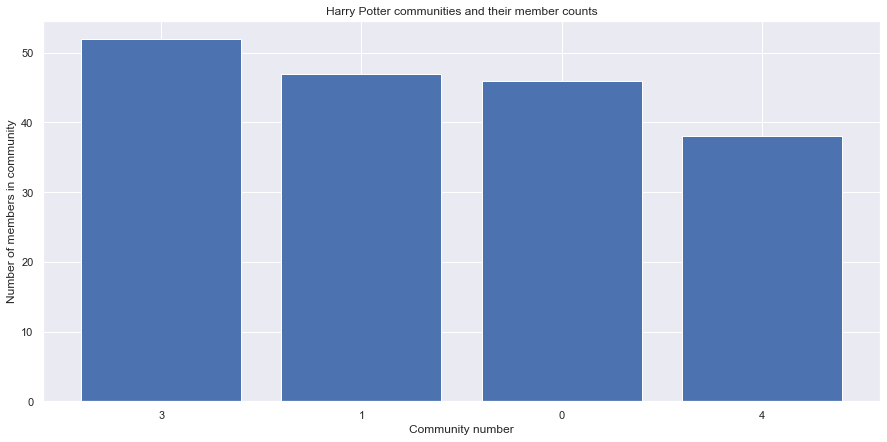

In [64]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of members in community')
plt.title('Harry Potter communities and their member counts')
plt.show()

In [65]:
communities_to_nodes = {}

for node in partition:
    if not communities_to_nodes.get(partition[node]):
        communities_to_nodes[partition[node]] = []
    communities_to_nodes[partition[node]].append(node)

In [66]:
for community_name in communities_to_nodes.keys():
    curr_comm = communities_to_nodes[community_name]
    curr_com_with_degrees = []
    for member in curr_comm:
        curr_com_with_degrees.append([member, GD_GCC_und.degree(member)])
    top_members = sorted(curr_com_with_degrees, key=lambda x: x[1], reverse=True)[:10]
    top_members_pd = pd.DataFrame(top_members)
    display(top_members_pd)

0    1
0   Harry Potter  137
1         Hagrid   57
2            Cho   46
3         Sirius   34
4  Lucius Malfoy   23
5          Fudge   16
6        Himself   16
7          Dobby   15
8          Guard   14
9    Death Eater   14

0   1
0  Albus Dumbledore  76
1         Voldemort  46
2        Mcgonagall  41
3             Night  39
4           Mad-Eye  31
5               Tom  29
6          Slughorn  25
7           Student  23
8          Students  22
9             Filch  18

0   1
0              Snape  52
1           Umbridge  34
2          Bellatrix  26
3               Girl  25
4              Witch  20
5              Class  19
6               Boys  19
7               Wood  16
8  Gilderoy Lockhart  16
9           Quirrell  15

0    1
0              Ron  131
1         Hermione  110
2          Neville   44
3     Draco Malfoy   37
4           Friend   34
5            Lupin   25
6  Professor Lupin   24
7            Voice   19
8           Seamus   12
9            Fleur   11

0   1
0           Ginny  31
1            Fred  31
2          Arthur  27
3            Luna  26
4          George  24
5             Lee  24
6    Mrs. Weasley  21
7    Sirius Black  19
8  Arthur Weasley  17
9           Tonks  16

In [67]:
# Generate the numbers of the top 10 communities and top 6 communities
top_10_communities = [el[0] for el in Counter(lovain_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(GD_GCC_und).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

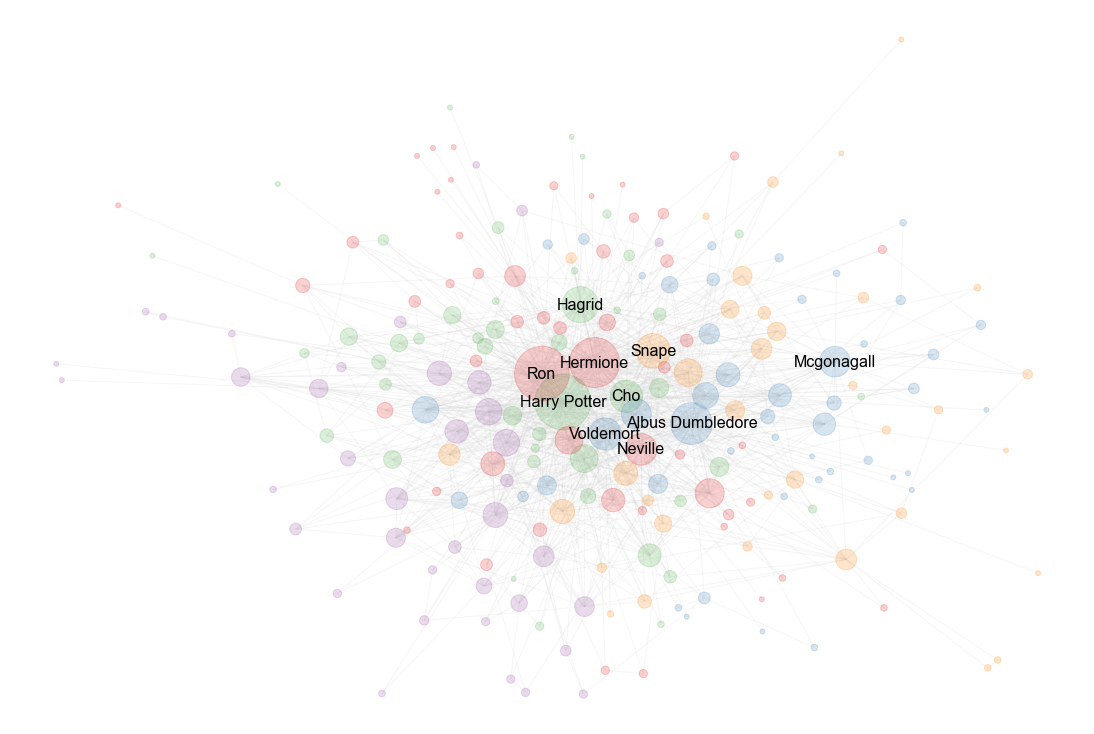

In [68]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
import matplotlib as mtpl
from fa2 import ForceAtlas2

cmap = mtpl.cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))


plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(GD_GCC_und, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(GD_GCC_und).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in lovain_communities]

# Generate the graph
nx.draw(GD_GCC_und, positions, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}
for node in GD_GCC_und.nodes():
    if node in top_nodes[:10]:
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(GD_GCC_und, positions, labels, font_size=16, font_color='black');